## Vesuvius Challenge - Ink Detection Training Notebook

### Setup

In [1]:
# # Pretrained weights
# # ref - https://github.com/kenshohara/3D-ResNets-PyTorch
# !pip install gdown
# !gdown 1Nb4abvIkkp_ydPFA9sNPT1WakoVKA8Fa

# # Utility packages for reading and visualizing volumes
# !pip install zarr imageio-ffmpeg

# save model checkpoints
!mkdir ./ckpts

In [2]:
import os
import gc
import sys
import zarr
import random
import imageio
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Video

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader

sys.path.append("./resnet3d")
from resnet3d import generate_model

### Config

In [3]:
LR = 1e-4
EPOCHS = 50
BATCH_SIZE = 32
CROP_SIZE = 256
Z_START = 24
Z_DIMS = 16
TRAIN_FRAGMENTS = ["1", "3"]
TEST_FRAGMENT = "2"

### Load data

In [4]:


FRAGMENTS_ZARR = {
    "1" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-1.zarr", mode="r"),
    "2" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-2.zarr", mode="r"),
    "3" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-3.zarr", mode="r")
}

FRAGMENTS_SHAPE = {k : v.mask.shape for k, v in FRAGMENTS_ZARR.items()}

### Visualise input

In [5]:
fragment = FRAGMENTS_ZARR["1"]
x, y = 2000, 2000

fragment_cropped = fragment.surface_volume[y:y+CROP_SIZE, x:x+CROP_SIZE, Z_START:Z_START+Z_DIMS]
imageio.mimwrite("fragment_crop.mp4", fragment_cropped.transpose(2, 0, 1), "ffmpeg")
Video("fragment_crop.mp4", height=256, width=256)

Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. C

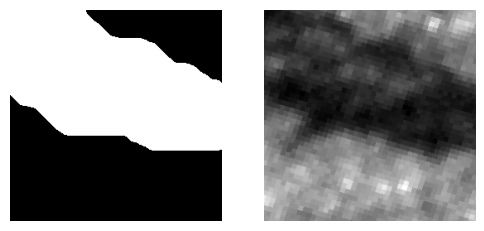

In [6]:
mask_cropped = fragment.truth[y:y+CROP_SIZE, x:x+CROP_SIZE]
ir_cropped = fragment.infrared[y:y+CROP_SIZE, x:x+CROP_SIZE]

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(mask_cropped, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ir_cropped, cmap="gray")
plt.axis("off")
plt.show()

In [7]:
del fragment, fragment_cropped, mask_cropped, ir_cropped
gc.collect()

4093

### Dataloaders

In [8]:
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# class VesuviusTrain(Dataset):
#     def __init__(self, fragments):
#         self.fragments = fragments
#         self.xys = []
        
#         for fragment in fragments:
#             H, W = FRAGMENTS_SHAPE[fragment]
#             for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
#                 for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
#                     self.xys.append((fragment, x, y, W, H))
        
#         train_aug_list = [
#                 # A.RandomResizedCrop(
#                 #     size, size, scale=(0.85, 1.0)),
#                 A.HorizontalFlip(p=0.5),
#                 A.VerticalFlip(p=0.5),
#                 A.RandomBrightnessContrast(p=0.75),
#                 A.CoarseDropout(max_holes=1, max_width=int(CROP_SIZE * 0.1), max_height=int(size * 0.1), 
#                                 mask_fill_value=0, p=0.5),
#                 A.ShiftScaleRotate(p=0.75),
#                 A.Rotate(limit=90, p=0.9), 
#                 A.OneOf([
#                         A.GaussNoise(var_limit=[10, 50]),
#                         A.GaussianBlur(),
#                         A.MotionBlur(),
#                         ], p=0.4),
#                 A.GridDistortion(num_steps=1, distort_limit=0.3, p=0.5),
                
#                 A.Cutout(max_h_size=int(size * 0.6),
#                          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
#                 A.Normalize(
#                     mean= [0] * Z_DIMS,
#                     std= [1] * Z_DIMS
#                 ),
#                 ToTensorV2(transpose_mask=True),
#             ]
        
        
        
#     def __getitem__(self, i):
#         fragment, x1, y1, W, H = self.xys[i]
#         z1, z2 = Z_START, Z_START+Z_DIMS
        
#         x_offset = random.randint(-32 if x1 != 0 else 0, 32)
#         y_offset = random.randint(-32 if y1 != 0 else 0, 32)
        
#         x1 += x_offset
#         y1 += y_offset
        
#         x2 = x1 + CROP_SIZE
#         y2 = y1 + CROP_SIZE
        
#         if x2 > W:
#             x1 -= x_offset
#             x2 -= x_offset
            
#         if y2 > H:
#             y1 -= y_offset
#             y2 -= y_offset
        
#         frag_crop = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, z1:z2]
#         mask_crop = FRAGMENTS_ZARR[fragment].truth[y1:y2, x1:x2]
        
#         if random.random() > 0.5:
#             frag_crop = np.flip(frag_crop, axis=1).copy()
#             mask_crop = np.flip(mask_crop, axis=1).copy()

#         frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)
#         frag_crop = frag_crop/65535.0
#         frag_crop = (frag_crop - 0.45)/0.225
        
#         mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).unsqueeze(0)
        
        
        
        
        
        
        
        
#         return frag_crop, mask_crop

#     def __len__(self):
#         return len(self.xys)

In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

class VesuviusTrain(Dataset):
    def __init__(self, fragments):
        self.fragments = fragments
        self.xys = []
        
        for fragment in fragments:
            H, W = FRAGMENTS_SHAPE[fragment]
            for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
                for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                    surface = FRAGMENTS_ZARR[fragment].surface_volume[y:y+CROP_SIZE, x:x+CROP_SIZE, 0]
                    if np.sum(surface) / (CROP_SIZE * CROP_SIZE) > 0.2:
                        self.xys.append((fragment, x, y, W, H))
        
        self.train_aug_list = [
                # A.RandomResizedCrop(
                #     size, size, scale=(0.85, 1.0)),
                
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                
                # A.RandomBrightnessContrast(p=0.75),
                A.CoarseDropout(max_holes=1, max_width=int(CROP_SIZE * 0.1), max_height=int(CROP_SIZE * 0.1), 
                                mask_fill_value=0, p=0.5),
                # A.ShiftScaleRotate(p=0.75),
                
                A.Rotate(limit=90, p=0.9), 
                
                # A.OneOf([
                #         A.GaussNoise(var_limit=[0.01, 0.05]),
                #         A.GaussianBlur(blur_limit=(3, 5), sigma_limit=0),
                #         A.MotionBlur(blur_limit=3),
                #         ], p=0.4),
                # A.GridDistortion(num_steps=1, distort_limit=0.1, p=0.5),
                # A.MultiplicativeNoise(per_channel=True, multiplier=(0.95, 1.05)),
                
                # A.Cutout(max_h_size=int(CROP_SIZE * 0.2),
                #          max_w_size=int(CROP_SIZE * 0.2), num_holes=1, p=1.0),
                
                ToTensorV2(transpose_mask=True),
            ]
        
        # Create the augmentation pipeline
        self.augmentations = A.Compose(self.train_aug_list)
        
        
        
    def __getitem__(self, i):
        fragment, x1, y1, W, H = self.xys[i]
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        x_offset = random.randint(-128 if x1 != 0 else 0, 128)
        y_offset = random.randint(-128 if y1 != 0 else 0, 128)
        
        x1 += x_offset
        y1 += y_offset
        
        x2 = x1 + CROP_SIZE
        y2 = y1 + CROP_SIZE
        
        if x2 > W:
            x1 -= x_offset
            x2 -= x_offset
            
        if y2 > H:
            y1 -= y_offset
            y2 -= y_offset
        
        frag_crop = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, z1:z2]
        mask_crop = FRAGMENTS_ZARR[fragment].truth[y1:y2, x1:x2]
        
        # if random.random() > 0.5:
        #     frag_crop = np.flip(frag_crop, axis=1).copy()
        #     mask_crop = np.flip(mask_crop, axis=1).copy()

        # Perform train augmentations

        frag_crop = frag_crop/65535.0
        
        
        # Apply the augmentations
        augmented = self.augmentations(image=frag_crop, mask=mask_crop)

        # Separate the image and mask
        frag_crop, mask_crop = augmented["image"], augmented["mask"]

        # normalize
        
        # frag_crop = (frag_crop - 0.45)/0.225
        
        frag_crop = frag_crop.unsqueeze(0) 
        mask_crop = mask_crop.float().unsqueeze(0)
        
        
        return frag_crop, mask_crop

    def __len__(self):
        return len(self.xys)

In [10]:
class VesuviusVal(Dataset):
    def __init__(self, fragment):
        self.fragment = FRAGMENTS_ZARR[fragment]
        self.xys = []
        
        H, W = FRAGMENTS_SHAPE[fragment]
        for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
            for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                self.xys.append((x, y))
                
    def __getitem__(self, i):
        x1, y1 = self.xys[i]
        x2, y2 = x1+CROP_SIZE, y1+CROP_SIZE
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        frag_crop = self.fragment.surface_volume[y1:y2, x1:x2, z1:z2]
        mask_crop = self.fragment.truth[y1:y2, x1:x2]

        frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)
        frag_crop = frag_crop/65535.0
        # frag_crop = (frag_crop - 0.45)/0.225
        
        mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).unsqueeze(0)
        return frag_crop, mask_crop, torch.tensor([x1, y1, x2, y2], dtype=torch.int32)

    def __len__(self):
        return len(self.xys)

In [11]:
dataset_train = VesuviusTrain(TRAIN_FRAGMENTS)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, num_workers=2,
                              shuffle=True, pin_memory=True, drop_last=True)
n_train = len(dataloader_train)

dataset_valid = VesuviusVal(TEST_FRAGMENT)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, num_workers=2,
                              shuffle=False, pin_memory=True, drop_last=False)
n_valid = len(dataloader_valid)

In [12]:
i = random.randint(0, len(dataset_train))
i=30
img = dataset_train[i][0]
img.min(), img.max()

(tensor(0.0005, dtype=torch.float64), tensor(1., dtype=torch.float64))

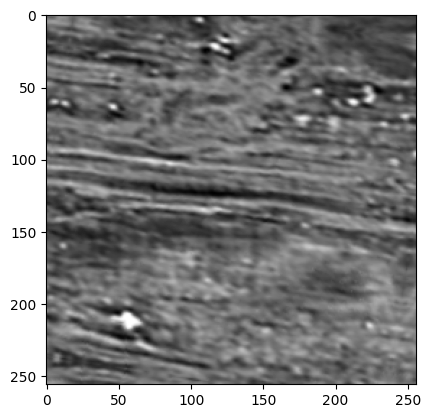

In [13]:
img_2 = img.squeeze(0).permute(1, 2, 0).numpy()
plt.imshow(img_2[:, :, 0], cmap="gray")

### Model
* Encoder is a 3D ResNet model. The architecture has been modified to remove temporal downsampling between blocks.
* A 2D decoder is used for predicting the segmentation map.
* The encoder feature maps are average pooled over the Z dimension before passing it to the decoder.

In [14]:
class Decoder(nn.Module):
    def __init__(self, encoder_dims, upscale):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(encoder_dims[i]+encoder_dims[i-1], encoder_dims[i-1], 3, 1, 1, bias=False),
                nn.BatchNorm2d(encoder_dims[i-1]),
                nn.ReLU(inplace=True)
            ) for i in range(1, len(encoder_dims))])

        self.logit = nn.Conv2d(encoder_dims[0], 1, 1, 1, 0)
        self.up = nn.Upsample(scale_factor=upscale, mode="bilinear")

    def forward(self, feature_maps):
        for i in range(len(feature_maps)-1, 0, -1):
            f_up = F.interpolate(feature_maps[i], scale_factor=2, mode="bilinear")
            f = torch.cat([feature_maps[i-1], f_up], dim=1)
            f_down = self.convs[i-1](f)
            feature_maps[i-1] = f_down

        x = self.logit(feature_maps[0])
        mask = self.up(x)
        return mask


class SegModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = generate_model(model_depth=18, n_input_channels=1)
        self.decoder = Decoder(encoder_dims=[64, 128, 256, 512], upscale=4)
        
    def forward(self, x):
        feat_maps = self.encoder(x)
        feat_maps_pooled = [torch.mean(f, dim=2) for f in feat_maps]
        pred_mask = self.decoder(feat_maps_pooled)
        return pred_mask
    
    def load_pretrained_weights(self, state_dict):
        # Convert 3 channel weights to single channel
        # ref - https://timm.fast.ai/models#Case-1:-When-the-number-of-input-channels-is-1
        conv1_weight = state_dict['conv1.weight']
        state_dict['conv1.weight'] = conv1_weight.sum(dim=1, keepdim=True)
        print(self.encoder.load_state_dict(state_dict, strict=False))

In [15]:
model = SegModel()
model.load_pretrained_weights(torch.load("/home/viktor/Documents/kaggle/vesuvius-challenge/experiments/3D-resnet/r3d18_K_200ep.pth")["state_dict"])
model = nn.DataParallel(model, device_ids=[0])

model = model.cuda()

_IncompatibleKeys(missing_keys=[], unexpected_keys=['fc.weight', 'fc.bias'])


In [16]:
x = torch.randn(5, 1, 16, 256, 256).cuda()
with torch.no_grad():
    y = model(x)
y.shape

torch.Size([5, 1, 256, 256])

### Competition metric (F0.5 Score)

In [17]:
# ref - https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
def fbeta_score(preds, targets, threshold, beta=0.5, smooth=1e-5):
    preds_t = torch.where(preds > threshold, 1.0, 0.0).float()
    y_true_count = targets.sum()
    
    ctp = preds_t[targets==1].sum()
    cfp = preds_t[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

### Training

In [18]:
scaler = amp.GradScaler()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR,
                                                steps_per_epoch=10, epochs=EPOCHS//10,
                                                pct_start=0.1)

In [19]:
gt_mask = torch.from_numpy(np.asarray(FRAGMENTS_ZARR[TEST_FRAGMENT].truth)).float().cuda()
gt_shape = FRAGMENTS_SHAPE[TEST_FRAGMENT]

In [20]:
import logging

logging.basicConfig(filename="training_log.txt", level=logging.INFO)


In [21]:
fbeta_best = 0.0
for epoch in range(1, EPOCHS+1):
    model.train()
    cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
    pbar_train = enumerate(dataloader_train)
    pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

    




    for i, (fragments, masks) in pbar_train:
        fragments, masks = fragments.cuda().half(), masks.cuda().half()
        
        
        optimizer.zero_grad()
        with amp.autocast():
            pred_masks = model(fragments)
            loss = criterion(pred_masks, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            mloss_train += loss.detach().item()

        gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
        pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
                                                              f"Loss: {mloss_train / (i + 1):.4f}"))
        
    scheduler.step()
    model.eval()
    pbar_val = enumerate(dataloader_valid)
    pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
    for i, (fragments, masks, xys) in pbar_val:
        fragments, masks = fragments.cuda(), masks.cuda()
        
        with torch.no_grad():
            pred_masks = model(fragments)
            mloss_val += criterion(pred_masks, masks).item()
            pred_masks = torch.sigmoid(pred_masks)
        
        for j, xy in enumerate(xys):
            final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = pred_masks[j, 0]

        pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
    
    for threshold in np.arange(0.2, 0.85, 0.05):
        fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
        print(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")
        
        if fbeta_best < fbeta:
            fbeta_best = fbeta
            torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_best_{fbeta_best:.4f}.pt")
    
    
    if epoch >= 10:
        torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_epoch_{epoch}.pt")

    # if epoch == 30:
    #     break

    print()

Epoch 1/50  Mem : 13.6GB  LR : 4.00E-06  Loss: 0.6791: 100%|██████████| 28/28 [00:16<00:00,  1.69it/s]                                                                                                                                                                           
Val Loss: 0.5945: 100%|██████████| 66/66 [00:16<00:00,  3.91it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.148011
Threshold : 0.25	FBeta : 0.148048
Threshold : 0.30	FBeta : 0.148364
Threshold : 0.35	FBeta : 0.152803
Threshold : 0.40	FBeta : 0.179325
Threshold : 0.45	FBeta : 0.210130
Threshold : 0.50	FBeta : 0.152582
Threshold : 0.55	FBeta : 0.022675
Threshold : 0.60	FBeta : 0.001306
Threshold : 0.65	FBeta : 0.000000
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 2/50  Mem : 18GB  LR : 1.81E-05  Loss: 0.6130: 100%|██████████| 28/28 [00:17<00:00,  1.63it/s]                                                                                                                                                                             
Val Loss: 0.5327: 100%|██████████| 66/66 [00:16<00:00,  3.90it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.149294
Threshold : 0.25	FBeta : 0.154188
Threshold : 0.30	FBeta : 0.166721
Threshold : 0.35	FBeta : 0.174745
Threshold : 0.40	FBeta : 0.160498
Threshold : 0.45	FBeta : 0.075046
Threshold : 0.50	FBeta : 0.013991
Threshold : 0.55	FBeta : 0.002215
Threshold : 0.60	FBeta : 0.000091
Threshold : 0.65	FBeta : 0.000000
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 3/50  Mem : 18GB  LR : 5.20E-05  Loss: 0.5329: 100%|██████████| 28/28 [00:17<00:00,  1.64it/s]                                                                                                                                                                             
Val Loss: 0.4692: 100%|██████████| 66/66 [00:17<00:00,  3.87it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.156260
Threshold : 0.25	FBeta : 0.168113
Threshold : 0.30	FBeta : 0.201197
Threshold : 0.35	FBeta : 0.223203
Threshold : 0.40	FBeta : 0.167174
Threshold : 0.45	FBeta : 0.092942
Threshold : 0.50	FBeta : 0.042550
Threshold : 0.55	FBeta : 0.013848
Threshold : 0.60	FBeta : 0.001528
Threshold : 0.65	FBeta : 0.000000
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 4/50  Mem : 18GB  LR : 8.59E-05  Loss: 0.4993: 100%|██████████| 28/28 [00:16<00:00,  1.68it/s]                                                                                                                                                                             
Val Loss: 0.4233: 100%|██████████| 66/66 [00:16<00:00,  3.90it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.152391
Threshold : 0.25	FBeta : 0.200386
Threshold : 0.30	FBeta : 0.245133
Threshold : 0.35	FBeta : 0.235066
Threshold : 0.40	FBeta : 0.093318
Threshold : 0.45	FBeta : 0.015779
Threshold : 0.50	FBeta : 0.002555
Threshold : 0.55	FBeta : 0.000020
Threshold : 0.60	FBeta : 0.000000
Threshold : 0.65	FBeta : 0.000000
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 5/50  Mem : 18GB  LR : 1.00E-04  Loss: 0.4643: 100%|██████████| 28/28 [00:16<00:00,  1.66it/s]                                                                                                                                                                             
Val Loss: 0.4052: 100%|██████████| 66/66 [00:16<00:00,  3.92it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.165920
Threshold : 0.25	FBeta : 0.243841
Threshold : 0.30	FBeta : 0.286666
Threshold : 0.35	FBeta : 0.318894
Threshold : 0.40	FBeta : 0.311846
Threshold : 0.45	FBeta : 0.248652
Threshold : 0.50	FBeta : 0.155394
Threshold : 0.55	FBeta : 0.035381
Threshold : 0.60	FBeta : 0.001157
Threshold : 0.65	FBeta : 0.000000
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 6/50  Mem : 18GB  LR : 9.99E-05  Loss: 0.4392: 100%|██████████| 28/28 [00:16<00:00,  1.66it/s]                                                                                                                                                                             
Val Loss: 0.3719: 100%|██████████| 66/66 [00:16<00:00,  3.89it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.236743
Threshold : 0.25	FBeta : 0.291983
Threshold : 0.30	FBeta : 0.336328
Threshold : 0.35	FBeta : 0.312998
Threshold : 0.40	FBeta : 0.261881
Threshold : 0.45	FBeta : 0.202517
Threshold : 0.50	FBeta : 0.131936
Threshold : 0.55	FBeta : 0.063806
Threshold : 0.60	FBeta : 0.021768
Threshold : 0.65	FBeta : 0.006433
Threshold : 0.70	FBeta : 0.000690
Threshold : 0.75	FBeta : 0.000009
Threshold : 0.80	FBeta : 0.000000



Epoch 7/50  Mem : 18GB  LR : 9.95E-05  Loss: 0.4162: 100%|██████████| 28/28 [00:16<00:00,  1.67it/s]                                                                                                                                                                             
Val Loss: 0.4120: 100%|██████████| 66/66 [00:16<00:00,  3.92it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.225343
Threshold : 0.25	FBeta : 0.253817
Threshold : 0.30	FBeta : 0.280545
Threshold : 0.35	FBeta : 0.296109
Threshold : 0.40	FBeta : 0.304699
Threshold : 0.45	FBeta : 0.309520
Threshold : 0.50	FBeta : 0.310176
Threshold : 0.55	FBeta : 0.306826
Threshold : 0.60	FBeta : 0.293926
Threshold : 0.65	FBeta : 0.267590
Threshold : 0.70	FBeta : 0.228073
Threshold : 0.75	FBeta : 0.176013
Threshold : 0.80	FBeta : 0.116157



Epoch 8/50  Mem : 18GB  LR : 9.89E-05  Loss: 0.4041: 100%|██████████| 28/28 [00:17<00:00,  1.65it/s]                                                                                                                                                                             
Val Loss: 0.5089: 100%|██████████| 66/66 [00:16<00:00,  3.92it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.185077
Threshold : 0.25	FBeta : 0.204833
Threshold : 0.30	FBeta : 0.185135
Threshold : 0.35	FBeta : 0.156919
Threshold : 0.40	FBeta : 0.125285
Threshold : 0.45	FBeta : 0.095487
Threshold : 0.50	FBeta : 0.067391
Threshold : 0.55	FBeta : 0.041667
Threshold : 0.60	FBeta : 0.021447
Threshold : 0.65	FBeta : 0.010531
Threshold : 0.70	FBeta : 0.005420
Threshold : 0.75	FBeta : 0.002509
Threshold : 0.80	FBeta : 0.000484



Epoch 9/50  Mem : 18GB  LR : 9.81E-05  Loss: 0.3921: 100%|██████████| 28/28 [00:16<00:00,  1.65it/s]                                                                                                                                                                             
Val Loss: 0.3658: 100%|██████████| 66/66 [00:16<00:00,  3.95it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.262803
Threshold : 0.25	FBeta : 0.213578
Threshold : 0.30	FBeta : 0.098465
Threshold : 0.35	FBeta : 0.057199
Threshold : 0.40	FBeta : 0.037717
Threshold : 0.45	FBeta : 0.026809
Threshold : 0.50	FBeta : 0.019667
Threshold : 0.55	FBeta : 0.014827
Threshold : 0.60	FBeta : 0.011635
Threshold : 0.65	FBeta : 0.009396
Threshold : 0.70	FBeta : 0.006703
Threshold : 0.75	FBeta : 0.004269
Threshold : 0.80	FBeta : 0.002414



Epoch 10/50  Mem : 18GB  LR : 9.70E-05  Loss: 0.3783: 100%|██████████| 28/28 [00:16<00:00,  1.66it/s]                                                                                                                                                                            
Val Loss: 0.3511: 100%|██████████| 66/66 [00:16<00:00,  3.93it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.323308
Threshold : 0.25	FBeta : 0.388647
Threshold : 0.30	FBeta : 0.395478
Threshold : 0.35	FBeta : 0.371911
Threshold : 0.40	FBeta : 0.323333
Threshold : 0.45	FBeta : 0.265145
Threshold : 0.50	FBeta : 0.198456
Threshold : 0.55	FBeta : 0.136321
Threshold : 0.60	FBeta : 0.085247
Threshold : 0.65	FBeta : 0.052316
Threshold : 0.70	FBeta : 0.033752
Threshold : 0.75	FBeta : 0.020915
Threshold : 0.80	FBeta : 0.012276



Epoch 11/50  Mem : 18GB  LR : 9.57E-05  Loss: 0.3624: 100%|██████████| 28/28 [00:16<00:00,  1.65it/s]                                                                                                                                                                            
Val Loss: 0.3646: 100%|██████████| 66/66 [00:16<00:00,  3.90it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.265057
Threshold : 0.25	FBeta : 0.120224
Threshold : 0.30	FBeta : 0.071711
Threshold : 0.35	FBeta : 0.047101
Threshold : 0.40	FBeta : 0.030626
Threshold : 0.45	FBeta : 0.019948
Threshold : 0.50	FBeta : 0.013940
Threshold : 0.55	FBeta : 0.009414
Threshold : 0.60	FBeta : 0.006795
Threshold : 0.65	FBeta : 0.005127
Threshold : 0.70	FBeta : 0.003626
Threshold : 0.75	FBeta : 0.002182
Threshold : 0.80	FBeta : 0.001062



Epoch 12/50  Mem : 18GB  LR : 9.41E-05  Loss: 0.3522: 100%|██████████| 28/28 [00:16<00:00,  1.68it/s]                                                                                                                                                                            
Val Loss: 0.3596: 100%|██████████| 66/66 [00:16<00:00,  3.95it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.297827
Threshold : 0.25	FBeta : 0.352853
Threshold : 0.30	FBeta : 0.363801
Threshold : 0.35	FBeta : 0.360894
Threshold : 0.40	FBeta : 0.347413
Threshold : 0.45	FBeta : 0.328599
Threshold : 0.50	FBeta : 0.305861
Threshold : 0.55	FBeta : 0.279702
Threshold : 0.60	FBeta : 0.251229
Threshold : 0.65	FBeta : 0.220311
Threshold : 0.70	FBeta : 0.187072
Threshold : 0.75	FBeta : 0.151378
Threshold : 0.80	FBeta : 0.114614



Epoch 13/50  Mem : 18GB  LR : 9.24E-05  Loss: 0.3482: 100%|██████████| 28/28 [00:16<00:00,  1.69it/s]                                                                                                                                                                            
Val Loss: 0.3692: 100%|██████████| 66/66 [00:16<00:00,  3.92it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.288946
Threshold : 0.25	FBeta : 0.279912
Threshold : 0.30	FBeta : 0.250395
Threshold : 0.35	FBeta : 0.210530
Threshold : 0.40	FBeta : 0.168025
Threshold : 0.45	FBeta : 0.115529
Threshold : 0.50	FBeta : 0.056337
Threshold : 0.55	FBeta : 0.037256
Threshold : 0.60	FBeta : 0.025363
Threshold : 0.65	FBeta : 0.016672
Threshold : 0.70	FBeta : 0.010412
Threshold : 0.75	FBeta : 0.006904
Threshold : 0.80	FBeta : 0.004846



Epoch 14/50  Mem : 18GB  LR : 9.05E-05  Loss: 0.3438: 100%|██████████| 28/28 [00:16<00:00,  1.68it/s]                                                                                                                                                                            
Val Loss: 0.3368: 100%|██████████| 66/66 [00:16<00:00,  3.94it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.378150
Threshold : 0.25	FBeta : 0.397787
Threshold : 0.30	FBeta : 0.394808
Threshold : 0.35	FBeta : 0.378125
Threshold : 0.40	FBeta : 0.353571
Threshold : 0.45	FBeta : 0.325587
Threshold : 0.50	FBeta : 0.292951
Threshold : 0.55	FBeta : 0.255960
Threshold : 0.60	FBeta : 0.215023
Threshold : 0.65	FBeta : 0.177407
Threshold : 0.70	FBeta : 0.141575
Threshold : 0.75	FBeta : 0.106723
Threshold : 0.80	FBeta : 0.073212



Epoch 15/50  Mem : 18GB  LR : 8.83E-05  Loss: 0.3439: 100%|██████████| 28/28 [00:17<00:00,  1.64it/s]                                                                                                                                                                            
Val Loss: 2.4956: 100%|██████████| 66/66 [00:16<00:00,  3.89it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.156949
Threshold : 0.25	FBeta : 0.118912
Threshold : 0.30	FBeta : 0.096233
Threshold : 0.35	FBeta : 0.078218
Threshold : 0.40	FBeta : 0.061921
Threshold : 0.45	FBeta : 0.044884
Threshold : 0.50	FBeta : 0.024318
Threshold : 0.55	FBeta : 0.017654
Threshold : 0.60	FBeta : 0.012787
Threshold : 0.65	FBeta : 0.008880
Threshold : 0.70	FBeta : 0.005992
Threshold : 0.75	FBeta : 0.004176
Threshold : 0.80	FBeta : 0.002835



Epoch 16/50  Mem : 18GB  LR : 8.60E-05  Loss: 0.3358: 100%|██████████| 28/28 [00:16<00:00,  1.68it/s]                                                                                                                                                                            
Val Loss: 0.3438: 100%|██████████| 66/66 [00:16<00:00,  3.92it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.333644
Threshold : 0.25	FBeta : 0.349220
Threshold : 0.30	FBeta : 0.352746
Threshold : 0.35	FBeta : 0.352248
Threshold : 0.40	FBeta : 0.344944
Threshold : 0.45	FBeta : 0.331970
Threshold : 0.50	FBeta : 0.312648
Threshold : 0.55	FBeta : 0.276152
Threshold : 0.60	FBeta : 0.232619
Threshold : 0.65	FBeta : 0.189025
Threshold : 0.70	FBeta : 0.148158
Threshold : 0.75	FBeta : 0.111984
Threshold : 0.80	FBeta : 0.079132



Epoch 17/50  Mem : 18GB  LR : 8.35E-05  Loss: 0.3356: 100%|██████████| 28/28 [00:16<00:00,  1.69it/s]                                                                                                                                                                            
Val Loss: 0.3851: 100%|██████████| 66/66 [00:16<00:00,  3.92it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.119187
Threshold : 0.25	FBeta : 0.077434
Threshold : 0.30	FBeta : 0.057748
Threshold : 0.35	FBeta : 0.043793
Threshold : 0.40	FBeta : 0.031086
Threshold : 0.45	FBeta : 0.021995
Threshold : 0.50	FBeta : 0.013941
Threshold : 0.55	FBeta : 0.009578
Threshold : 0.60	FBeta : 0.006944
Threshold : 0.65	FBeta : 0.005880
Threshold : 0.70	FBeta : 0.005232
Threshold : 0.75	FBeta : 0.004682
Threshold : 0.80	FBeta : 0.003322



Epoch 18/50  Mem : 18GB  LR : 8.08E-05  Loss: 0.3149: 100%|██████████| 28/28 [00:16<00:00,  1.67it/s]                                                                                                                                                                            
Val Loss: 0.3336: 100%|██████████| 66/66 [00:16<00:00,  3.92it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.321217
Threshold : 0.25	FBeta : 0.352198
Threshold : 0.30	FBeta : 0.372277
Threshold : 0.35	FBeta : 0.386066
Threshold : 0.40	FBeta : 0.395675
Threshold : 0.45	FBeta : 0.399632
Threshold : 0.50	FBeta : 0.396649
Threshold : 0.55	FBeta : 0.382538
Threshold : 0.60	FBeta : 0.363041
Threshold : 0.65	FBeta : 0.336855
Threshold : 0.70	FBeta : 0.306759
Threshold : 0.75	FBeta : 0.271753
Threshold : 0.80	FBeta : 0.230002



Epoch 19/50  Mem : 18GB  LR : 7.80E-05  Loss: 0.3180: 100%|██████████| 28/28 [00:16<00:00,  1.69it/s]                                                                                                                                                                            
Val Loss: 0.3354: 100%|██████████| 66/66 [00:17<00:00,  3.88it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.382891
Threshold : 0.25	FBeta : 0.360193
Threshold : 0.30	FBeta : 0.325366
Threshold : 0.35	FBeta : 0.288768
Threshold : 0.40	FBeta : 0.246890
Threshold : 0.45	FBeta : 0.198943
Threshold : 0.50	FBeta : 0.140114
Threshold : 0.55	FBeta : 0.112447
Threshold : 0.60	FBeta : 0.088464
Threshold : 0.65	FBeta : 0.068910
Threshold : 0.70	FBeta : 0.053263
Threshold : 0.75	FBeta : 0.040320
Threshold : 0.80	FBeta : 0.030157



Epoch 20/50  Mem : 18GB  LR : 7.50E-05  Loss: 0.3136: 100%|██████████| 28/28 [00:16<00:00,  1.66it/s]                                                                                                                                                                            
Val Loss: 0.3418: 100%|██████████| 66/66 [00:16<00:00,  3.89it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.299834
Threshold : 0.25	FBeta : 0.267614
Threshold : 0.30	FBeta : 0.230944
Threshold : 0.35	FBeta : 0.187111
Threshold : 0.40	FBeta : 0.145587
Threshold : 0.45	FBeta : 0.104159
Threshold : 0.50	FBeta : 0.067022
Threshold : 0.55	FBeta : 0.044789
Threshold : 0.60	FBeta : 0.029324
Threshold : 0.65	FBeta : 0.020423
Threshold : 0.70	FBeta : 0.015115
Threshold : 0.75	FBeta : 0.010595
Threshold : 0.80	FBeta : 0.006618



Epoch 21/50  Mem : 18GB  LR : 7.19E-05  Loss: 0.2982: 100%|██████████| 28/28 [00:16<00:00,  1.69it/s]                                                                                                                                                                            
Val Loss: 0.3428: 100%|██████████| 66/66 [00:16<00:00,  3.93it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.338951
Threshold : 0.25	FBeta : 0.288205
Threshold : 0.30	FBeta : 0.241553
Threshold : 0.35	FBeta : 0.199967
Threshold : 0.40	FBeta : 0.159321
Threshold : 0.45	FBeta : 0.113198
Threshold : 0.50	FBeta : 0.071412
Threshold : 0.55	FBeta : 0.050890
Threshold : 0.60	FBeta : 0.036160
Threshold : 0.65	FBeta : 0.026920
Threshold : 0.70	FBeta : 0.018615
Threshold : 0.75	FBeta : 0.011541
Threshold : 0.80	FBeta : 0.006908



Epoch 22/50  Mem : 18GB  LR : 6.87E-05  Loss: 0.3105: 100%|██████████| 28/28 [00:16<00:00,  1.66it/s]                                                                                                                                                                            
Val Loss: 0.3433: 100%|██████████| 66/66 [00:16<00:00,  3.90it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.338366
Threshold : 0.25	FBeta : 0.292725
Threshold : 0.30	FBeta : 0.251218
Threshold : 0.35	FBeta : 0.217308
Threshold : 0.40	FBeta : 0.188025
Threshold : 0.45	FBeta : 0.158151
Threshold : 0.50	FBeta : 0.129116
Threshold : 0.55	FBeta : 0.104476
Threshold : 0.60	FBeta : 0.082872
Threshold : 0.65	FBeta : 0.061484
Threshold : 0.70	FBeta : 0.044729
Threshold : 0.75	FBeta : 0.030663
Threshold : 0.80	FBeta : 0.019590



Epoch 23/50  Mem : 18GB  LR : 6.55E-05  Loss: 0.3061: 100%|██████████| 28/28 [00:16<00:00,  1.67it/s]                                                                                                                                                                            
Val Loss: 0.3357: 100%|██████████| 66/66 [00:16<00:00,  3.92it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.345626
Threshold : 0.25	FBeta : 0.338957
Threshold : 0.30	FBeta : 0.324413
Threshold : 0.35	FBeta : 0.291714
Threshold : 0.40	FBeta : 0.254249
Threshold : 0.45	FBeta : 0.214083
Threshold : 0.50	FBeta : 0.159805
Threshold : 0.55	FBeta : 0.126668
Threshold : 0.60	FBeta : 0.099847
Threshold : 0.65	FBeta : 0.075009
Threshold : 0.70	FBeta : 0.051455
Threshold : 0.75	FBeta : 0.032506
Threshold : 0.80	FBeta : 0.020488



Epoch 24/50  Mem : 18GB  LR : 6.21E-05  Loss: 0.2945: 100%|██████████| 28/28 [00:16<00:00,  1.66it/s]                                                                                                                                                                            
Val Loss: 0.3454: 100%|██████████| 66/66 [00:16<00:00,  3.94it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.304183
Threshold : 0.25	FBeta : 0.242893
Threshold : 0.30	FBeta : 0.196624
Threshold : 0.35	FBeta : 0.160123
Threshold : 0.40	FBeta : 0.132115
Threshold : 0.45	FBeta : 0.107707
Threshold : 0.50	FBeta : 0.087127
Threshold : 0.55	FBeta : 0.068393
Threshold : 0.60	FBeta : 0.052559
Threshold : 0.65	FBeta : 0.039279
Threshold : 0.70	FBeta : 0.028601
Threshold : 0.75	FBeta : 0.021198
Threshold : 0.80	FBeta : 0.015353



Epoch 25/50  Mem : 18GB  LR : 5.87E-05  Loss: 0.2927: 100%|██████████| 28/28 [00:16<00:00,  1.67it/s]                                                                                                                                                                            
Val Loss: 0.3421: 100%|██████████| 66/66 [00:16<00:00,  3.90it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.288008
Threshold : 0.25	FBeta : 0.255803
Threshold : 0.30	FBeta : 0.227029
Threshold : 0.35	FBeta : 0.199436
Threshold : 0.40	FBeta : 0.165521
Threshold : 0.45	FBeta : 0.134520
Threshold : 0.50	FBeta : 0.105590
Threshold : 0.55	FBeta : 0.081593
Threshold : 0.60	FBeta : 0.063829
Threshold : 0.65	FBeta : 0.049113
Threshold : 0.70	FBeta : 0.035559
Threshold : 0.75	FBeta : 0.025370
Threshold : 0.80	FBeta : 0.016369



Epoch 26/50  Mem : 18GB  LR : 5.52E-05  Loss: 0.2932: 100%|██████████| 28/28 [00:16<00:00,  1.65it/s]                                                                                                                                                                            
Val Loss: 0.3261: 100%|██████████| 66/66 [00:16<00:00,  3.91it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.401534
Threshold : 0.25	FBeta : 0.397969
Threshold : 0.30	FBeta : 0.382823
Threshold : 0.35	FBeta : 0.361898
Threshold : 0.40	FBeta : 0.336928
Threshold : 0.45	FBeta : 0.303544
Threshold : 0.50	FBeta : 0.266585
Threshold : 0.55	FBeta : 0.234626
Threshold : 0.60	FBeta : 0.202881
Threshold : 0.65	FBeta : 0.171801
Threshold : 0.70	FBeta : 0.142711
Threshold : 0.75	FBeta : 0.113801
Threshold : 0.80	FBeta : 0.086100



Epoch 27/50  Mem : 18GB  LR : 5.17E-05  Loss: 0.2824: 100%|██████████| 28/28 [00:16<00:00,  1.68it/s]                                                                                                                                                                            
Val Loss: 0.3490: 100%|██████████| 66/66 [00:17<00:00,  3.87it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.246435
Threshold : 0.25	FBeta : 0.199136
Threshold : 0.30	FBeta : 0.156725
Threshold : 0.35	FBeta : 0.122664
Threshold : 0.40	FBeta : 0.095858
Threshold : 0.45	FBeta : 0.070937
Threshold : 0.50	FBeta : 0.053254
Threshold : 0.55	FBeta : 0.039793
Threshold : 0.60	FBeta : 0.029035
Threshold : 0.65	FBeta : 0.020960
Threshold : 0.70	FBeta : 0.015033
Threshold : 0.75	FBeta : 0.009940
Threshold : 0.80	FBeta : 0.005981



Epoch 28/50  Mem : 18GB  LR : 4.83E-05  Loss: 0.2775: 100%|██████████| 28/28 [00:16<00:00,  1.67it/s]                                                                                                                                                                            
Val Loss: 0.3200: 100%|██████████| 66/66 [00:16<00:00,  3.90it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.357285
Threshold : 0.25	FBeta : 0.382463
Threshold : 0.30	FBeta : 0.401036
Threshold : 0.35	FBeta : 0.411800
Threshold : 0.40	FBeta : 0.415140
Threshold : 0.45	FBeta : 0.408426
Threshold : 0.50	FBeta : 0.383039
Threshold : 0.55	FBeta : 0.363561
Threshold : 0.60	FBeta : 0.338246
Threshold : 0.65	FBeta : 0.310954
Threshold : 0.70	FBeta : 0.280310
Threshold : 0.75	FBeta : 0.247458
Threshold : 0.80	FBeta : 0.210696



Epoch 29/50  Mem : 18GB  LR : 4.48E-05  Loss: 0.2813: 100%|██████████| 28/28 [00:17<00:00,  1.64it/s]                                                                                                                                                                            
Val Loss: 0.3285: 100%|██████████| 66/66 [00:16<00:00,  3.89it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.410635
Threshold : 0.25	FBeta : 0.389642
Threshold : 0.30	FBeta : 0.364178
Threshold : 0.35	FBeta : 0.336745
Threshold : 0.40	FBeta : 0.308284
Threshold : 0.45	FBeta : 0.278149
Threshold : 0.50	FBeta : 0.247824
Threshold : 0.55	FBeta : 0.219469
Threshold : 0.60	FBeta : 0.193826
Threshold : 0.65	FBeta : 0.169428
Threshold : 0.70	FBeta : 0.145091
Threshold : 0.75	FBeta : 0.120510
Threshold : 0.80	FBeta : 0.094342



Epoch 30/50  Mem : 18GB  LR : 4.13E-05  Loss: 0.2736: 100%|██████████| 28/28 [00:16<00:00,  1.67it/s]                                                                                                                                                                            
Val Loss: 0.3490: 100%|██████████| 66/66 [00:16<00:00,  3.93it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.280341
Threshold : 0.25	FBeta : 0.243297
Threshold : 0.30	FBeta : 0.211776
Threshold : 0.35	FBeta : 0.188792
Threshold : 0.40	FBeta : 0.167299
Threshold : 0.45	FBeta : 0.142208
Threshold : 0.50	FBeta : 0.112407
Threshold : 0.55	FBeta : 0.088984
Threshold : 0.60	FBeta : 0.068424
Threshold : 0.65	FBeta : 0.050431
Threshold : 0.70	FBeta : 0.038172
Threshold : 0.75	FBeta : 0.028185
Threshold : 0.80	FBeta : 0.018934



Epoch 31/50  Mem : 18GB  LR : 3.79E-05  Loss: 0.2648: 100%|██████████| 28/28 [00:16<00:00,  1.67it/s]                                                                                                                                                                            
Val Loss: 0.3518: 100%|██████████| 66/66 [00:16<00:00,  3.93it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.271043
Threshold : 0.25	FBeta : 0.237900
Threshold : 0.30	FBeta : 0.211200
Threshold : 0.35	FBeta : 0.185281
Threshold : 0.40	FBeta : 0.157571
Threshold : 0.45	FBeta : 0.132877
Threshold : 0.50	FBeta : 0.107954
Threshold : 0.55	FBeta : 0.087757
Threshold : 0.60	FBeta : 0.070874
Threshold : 0.65	FBeta : 0.056019
Threshold : 0.70	FBeta : 0.043189
Threshold : 0.75	FBeta : 0.032619
Threshold : 0.80	FBeta : 0.021403



Epoch 32/50  Mem : 18GB  LR : 3.45E-05  Loss: 0.2781: 100%|██████████| 28/28 [00:16<00:00,  1.65it/s]                                                                                                                                                                            
Val Loss: 0.3362: 100%|██████████| 66/66 [00:16<00:00,  3.93it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.351939
Threshold : 0.25	FBeta : 0.326410
Threshold : 0.30	FBeta : 0.299349
Threshold : 0.35	FBeta : 0.271773
Threshold : 0.40	FBeta : 0.239669
Threshold : 0.45	FBeta : 0.205648
Threshold : 0.50	FBeta : 0.165793
Threshold : 0.55	FBeta : 0.133003
Threshold : 0.60	FBeta : 0.105809
Threshold : 0.65	FBeta : 0.083848
Threshold : 0.70	FBeta : 0.065364
Threshold : 0.75	FBeta : 0.050640
Threshold : 0.80	FBeta : 0.037115



Epoch 33/50  Mem : 18GB  LR : 3.13E-05  Loss: 0.2717: 100%|██████████| 28/28 [00:16<00:00,  1.68it/s]                                                                                                                                                                            
Val Loss: 0.3176: 100%|██████████| 66/66 [00:16<00:00,  3.93it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.424949
Threshold : 0.25	FBeta : 0.439945
Threshold : 0.30	FBeta : 0.430271
Threshold : 0.35	FBeta : 0.414859
Threshold : 0.40	FBeta : 0.391196
Threshold : 0.45	FBeta : 0.360851
Threshold : 0.50	FBeta : 0.318695
Threshold : 0.55	FBeta : 0.281076
Threshold : 0.60	FBeta : 0.243411
Threshold : 0.65	FBeta : 0.208031
Threshold : 0.70	FBeta : 0.171538
Threshold : 0.75	FBeta : 0.135827
Threshold : 0.80	FBeta : 0.099694



Epoch 34/50  Mem : 18GB  LR : 2.81E-05  Loss: 0.2705: 100%|██████████| 28/28 [00:16<00:00,  1.70it/s]                                                                                                                                                                            
Val Loss: 0.3419: 100%|██████████| 66/66 [00:16<00:00,  3.92it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.334218
Threshold : 0.25	FBeta : 0.276260
Threshold : 0.30	FBeta : 0.228476
Threshold : 0.35	FBeta : 0.190106
Threshold : 0.40	FBeta : 0.158298
Threshold : 0.45	FBeta : 0.127612
Threshold : 0.50	FBeta : 0.103158
Threshold : 0.55	FBeta : 0.084352
Threshold : 0.60	FBeta : 0.066063
Threshold : 0.65	FBeta : 0.052340
Threshold : 0.70	FBeta : 0.040636
Threshold : 0.75	FBeta : 0.030325
Threshold : 0.80	FBeta : 0.021417



Epoch 35/50  Mem : 18GB  LR : 2.50E-05  Loss: 0.2676: 100%|██████████| 28/28 [00:16<00:00,  1.66it/s]                                                                                                                                                                            
Val Loss: 0.3331: 100%|██████████| 66/66 [00:17<00:00,  3.85it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.395028
Threshold : 0.25	FBeta : 0.368374
Threshold : 0.30	FBeta : 0.339944
Threshold : 0.35	FBeta : 0.308363
Threshold : 0.40	FBeta : 0.275822
Threshold : 0.45	FBeta : 0.240125
Threshold : 0.50	FBeta : 0.203165
Threshold : 0.55	FBeta : 0.171675
Threshold : 0.60	FBeta : 0.142434
Threshold : 0.65	FBeta : 0.116796
Threshold : 0.70	FBeta : 0.092962
Threshold : 0.75	FBeta : 0.073407
Threshold : 0.80	FBeta : 0.054777



Epoch 36/50  Mem : 18GB  LR : 2.20E-05  Loss: 0.2621: 100%|██████████| 28/28 [00:16<00:00,  1.67it/s]                                                                                                                                                                            
Val Loss: 0.3311: 100%|██████████| 66/66 [00:16<00:00,  3.92it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.379131
Threshold : 0.25	FBeta : 0.368101
Threshold : 0.30	FBeta : 0.340810
Threshold : 0.35	FBeta : 0.305563
Threshold : 0.40	FBeta : 0.270509
Threshold : 0.45	FBeta : 0.233567
Threshold : 0.50	FBeta : 0.193170
Threshold : 0.55	FBeta : 0.163013
Threshold : 0.60	FBeta : 0.135497
Threshold : 0.65	FBeta : 0.110691
Threshold : 0.70	FBeta : 0.088721
Threshold : 0.75	FBeta : 0.069215
Threshold : 0.80	FBeta : 0.051210



Epoch 37/50  Mem : 18GB  LR : 1.92E-05  Loss: 0.2560: 100%|██████████| 28/28 [00:16<00:00,  1.65it/s]                                                                                                                                                                            
Val Loss: 0.3254: 100%|██████████| 66/66 [00:16<00:00,  3.91it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.383344
Threshold : 0.25	FBeta : 0.379419
Threshold : 0.30	FBeta : 0.378996
Threshold : 0.35	FBeta : 0.369817
Threshold : 0.40	FBeta : 0.349164
Threshold : 0.45	FBeta : 0.305310
Threshold : 0.50	FBeta : 0.252414
Threshold : 0.55	FBeta : 0.220821
Threshold : 0.60	FBeta : 0.191961
Threshold : 0.65	FBeta : 0.163328
Threshold : 0.70	FBeta : 0.135849
Threshold : 0.75	FBeta : 0.110398
Threshold : 0.80	FBeta : 0.085792



Epoch 38/50  Mem : 18GB  LR : 1.65E-05  Loss: 0.2545: 100%|██████████| 28/28 [00:16<00:00,  1.67it/s]                                                                                                                                                                            
Val Loss: 0.3312: 100%|██████████| 66/66 [00:16<00:00,  3.92it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.420397
Threshold : 0.25	FBeta : 0.390038
Threshold : 0.30	FBeta : 0.350738
Threshold : 0.35	FBeta : 0.309484
Threshold : 0.40	FBeta : 0.263417
Threshold : 0.45	FBeta : 0.209342
Threshold : 0.50	FBeta : 0.153479
Threshold : 0.55	FBeta : 0.124407
Threshold : 0.60	FBeta : 0.102408
Threshold : 0.65	FBeta : 0.083227
Threshold : 0.70	FBeta : 0.065499
Threshold : 0.75	FBeta : 0.050325
Threshold : 0.80	FBeta : 0.037292



Epoch 39/50  Mem : 18GB  LR : 1.40E-05  Loss: 0.2541: 100%|██████████| 28/28 [00:16<00:00,  1.65it/s]                                                                                                                                                                            
Val Loss: 0.3354: 100%|██████████| 66/66 [00:16<00:00,  3.95it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.396829
Threshold : 0.25	FBeta : 0.367059
Threshold : 0.30	FBeta : 0.336631
Threshold : 0.35	FBeta : 0.301741
Threshold : 0.40	FBeta : 0.263392
Threshold : 0.45	FBeta : 0.225014
Threshold : 0.50	FBeta : 0.182248
Threshold : 0.55	FBeta : 0.150826
Threshold : 0.60	FBeta : 0.124929
Threshold : 0.65	FBeta : 0.103041
Threshold : 0.70	FBeta : 0.083698
Threshold : 0.75	FBeta : 0.066441
Threshold : 0.80	FBeta : 0.050526



Epoch 40/50  Mem : 18GB  LR : 1.17E-05  Loss: 0.2478: 100%|██████████| 28/28 [00:16<00:00,  1.66it/s]                                                                                                                                                                            
Val Loss: 0.3436: 100%|██████████| 66/66 [00:17<00:00,  3.87it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.367366
Threshold : 0.25	FBeta : 0.333690
Threshold : 0.30	FBeta : 0.300559
Threshold : 0.35	FBeta : 0.268290
Threshold : 0.40	FBeta : 0.236592
Threshold : 0.45	FBeta : 0.207095
Threshold : 0.50	FBeta : 0.177518
Threshold : 0.55	FBeta : 0.154340
Threshold : 0.60	FBeta : 0.131599
Threshold : 0.65	FBeta : 0.110150
Threshold : 0.70	FBeta : 0.091605
Threshold : 0.75	FBeta : 0.074516
Threshold : 0.80	FBeta : 0.058489



Epoch 41/50  Mem : 18GB  LR : 9.55E-06  Loss: 0.2566: 100%|██████████| 28/28 [00:16<00:00,  1.68it/s]                                                                                                                                                                            
Val Loss: 0.3422: 100%|██████████| 66/66 [00:16<00:00,  3.96it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.332691
Threshold : 0.25	FBeta : 0.310651
Threshold : 0.30	FBeta : 0.285583
Threshold : 0.35	FBeta : 0.260008
Threshold : 0.40	FBeta : 0.233303
Threshold : 0.45	FBeta : 0.200837
Threshold : 0.50	FBeta : 0.159931
Threshold : 0.55	FBeta : 0.131651
Threshold : 0.60	FBeta : 0.108917
Threshold : 0.65	FBeta : 0.089452
Threshold : 0.70	FBeta : 0.072521
Threshold : 0.75	FBeta : 0.056898
Threshold : 0.80	FBeta : 0.042745



Epoch 42/50  Mem : 18GB  LR : 7.60E-06  Loss: 0.2530: 100%|██████████| 28/28 [00:17<00:00,  1.63it/s]                                                                                                                                                                            
Val Loss: 0.3340: 100%|██████████| 66/66 [00:16<00:00,  3.89it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.403177
Threshold : 0.25	FBeta : 0.380021
Threshold : 0.30	FBeta : 0.354953
Threshold : 0.35	FBeta : 0.326863
Threshold : 0.40	FBeta : 0.296341
Threshold : 0.45	FBeta : 0.264556
Threshold : 0.50	FBeta : 0.228479
Threshold : 0.55	FBeta : 0.197578
Threshold : 0.60	FBeta : 0.168674
Threshold : 0.65	FBeta : 0.141020
Threshold : 0.70	FBeta : 0.116289
Threshold : 0.75	FBeta : 0.094646
Threshold : 0.80	FBeta : 0.074607



Epoch 43/50  Mem : 18GB  LR : 5.85E-06  Loss: 0.2496: 100%|██████████| 28/28 [00:16<00:00,  1.65it/s]                                                                                                                                                                            
Val Loss: 0.3434: 100%|██████████| 66/66 [00:16<00:00,  3.90it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.354011
Threshold : 0.25	FBeta : 0.313202
Threshold : 0.30	FBeta : 0.269081
Threshold : 0.35	FBeta : 0.227479
Threshold : 0.40	FBeta : 0.192944
Threshold : 0.45	FBeta : 0.163627
Threshold : 0.50	FBeta : 0.134340
Threshold : 0.55	FBeta : 0.110294
Threshold : 0.60	FBeta : 0.090199
Threshold : 0.65	FBeta : 0.071968
Threshold : 0.70	FBeta : 0.055916
Threshold : 0.75	FBeta : 0.042244
Threshold : 0.80	FBeta : 0.031684



Epoch 44/50  Mem : 18GB  LR : 4.32E-06  Loss: 0.2487: 100%|██████████| 28/28 [00:16<00:00,  1.65it/s]                                                                                                                                                                            
Val Loss: 0.3472: 100%|██████████| 66/66 [00:16<00:00,  3.93it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.331135
Threshold : 0.25	FBeta : 0.286655
Threshold : 0.30	FBeta : 0.248516
Threshold : 0.35	FBeta : 0.212270
Threshold : 0.40	FBeta : 0.179527
Threshold : 0.45	FBeta : 0.149551
Threshold : 0.50	FBeta : 0.123137
Threshold : 0.55	FBeta : 0.104050
Threshold : 0.60	FBeta : 0.086759
Threshold : 0.65	FBeta : 0.070957
Threshold : 0.70	FBeta : 0.057206
Threshold : 0.75	FBeta : 0.043726
Threshold : 0.80	FBeta : 0.032765



Epoch 45/50  Mem : 18GB  LR : 3.02E-06  Loss: 0.2438: 100%|██████████| 28/28 [00:16<00:00,  1.67it/s]                                                                                                                                                                            
Val Loss: 0.3361: 100%|██████████| 66/66 [00:16<00:00,  3.89it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.388097
Threshold : 0.25	FBeta : 0.361817
Threshold : 0.30	FBeta : 0.330681
Threshold : 0.35	FBeta : 0.294957
Threshold : 0.40	FBeta : 0.257482
Threshold : 0.45	FBeta : 0.221579
Threshold : 0.50	FBeta : 0.188150
Threshold : 0.55	FBeta : 0.157953
Threshold : 0.60	FBeta : 0.130419
Threshold : 0.65	FBeta : 0.105643
Threshold : 0.70	FBeta : 0.085914
Threshold : 0.75	FBeta : 0.068190
Threshold : 0.80	FBeta : 0.051965



Epoch 46/50  Mem : 18GB  LR : 1.94E-06  Loss: 0.2514: 100%|██████████| 28/28 [00:17<00:00,  1.64it/s]                                                                                                                                                                            
Val Loss: 0.3360: 100%|██████████| 66/66 [00:16<00:00,  3.94it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.388547
Threshold : 0.25	FBeta : 0.365266
Threshold : 0.30	FBeta : 0.334818
Threshold : 0.35	FBeta : 0.300207
Threshold : 0.40	FBeta : 0.265564
Threshold : 0.45	FBeta : 0.231281
Threshold : 0.50	FBeta : 0.196742
Threshold : 0.55	FBeta : 0.167007
Threshold : 0.60	FBeta : 0.141353
Threshold : 0.65	FBeta : 0.117568
Threshold : 0.70	FBeta : 0.096907
Threshold : 0.75	FBeta : 0.078675
Threshold : 0.80	FBeta : 0.060529



Epoch 47/50  Mem : 18GB  LR : 1.09E-06  Loss: 0.2462: 100%|██████████| 28/28 [00:16<00:00,  1.67it/s]                                                                                                                                                                            
Val Loss: 0.3382: 100%|██████████| 66/66 [00:16<00:00,  3.89it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.375272
Threshold : 0.25	FBeta : 0.351939
Threshold : 0.30	FBeta : 0.318167
Threshold : 0.35	FBeta : 0.280641
Threshold : 0.40	FBeta : 0.242335
Threshold : 0.45	FBeta : 0.206738
Threshold : 0.50	FBeta : 0.171373
Threshold : 0.55	FBeta : 0.143427
Threshold : 0.60	FBeta : 0.120248
Threshold : 0.65	FBeta : 0.099105
Threshold : 0.70	FBeta : 0.080411
Threshold : 0.75	FBeta : 0.063186
Threshold : 0.80	FBeta : 0.048071



Epoch 48/50  Mem : 18GB  LR : 4.87E-07  Loss: 0.2420: 100%|██████████| 28/28 [00:16<00:00,  1.65it/s]                                                                                                                                                                            
Val Loss: 0.3379: 100%|██████████| 66/66 [00:16<00:00,  3.90it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.383693
Threshold : 0.25	FBeta : 0.357696
Threshold : 0.30	FBeta : 0.323796
Threshold : 0.35	FBeta : 0.287579
Threshold : 0.40	FBeta : 0.252417
Threshold : 0.45	FBeta : 0.216968
Threshold : 0.50	FBeta : 0.183210
Threshold : 0.55	FBeta : 0.155000
Threshold : 0.60	FBeta : 0.131115
Threshold : 0.65	FBeta : 0.109423
Threshold : 0.70	FBeta : 0.089604
Threshold : 0.75	FBeta : 0.072275
Threshold : 0.80	FBeta : 0.055495



Epoch 49/50  Mem : 18GB  LR : 1.22E-07  Loss: 0.2473: 100%|██████████| 28/28 [00:16<00:00,  1.68it/s]                                                                                                                                                                            
Val Loss: 0.3388: 100%|██████████| 66/66 [00:16<00:00,  3.94it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.342983
Threshold : 0.25	FBeta : 0.331746
Threshold : 0.30	FBeta : 0.315111
Threshold : 0.35	FBeta : 0.284770
Threshold : 0.40	FBeta : 0.248463
Threshold : 0.45	FBeta : 0.212121
Threshold : 0.50	FBeta : 0.175699
Threshold : 0.55	FBeta : 0.147020
Threshold : 0.60	FBeta : 0.122650
Threshold : 0.65	FBeta : 0.101396
Threshold : 0.70	FBeta : 0.081944
Threshold : 0.75	FBeta : 0.064113
Threshold : 0.80	FBeta : 0.048806



Epoch 50/50  Mem : 18GB  LR : 4.00E-10  Loss: 0.2424: 100%|██████████| 28/28 [00:16<00:00,  1.65it/s]                                                                                                                                                                            
Val Loss: 0.3378: 100%|██████████| 66/66 [00:16<00:00,  3.92it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.379857
Threshold : 0.25	FBeta : 0.355452
Threshold : 0.30	FBeta : 0.322003
Threshold : 0.35	FBeta : 0.284867
Threshold : 0.40	FBeta : 0.247596
Threshold : 0.45	FBeta : 0.211272
Threshold : 0.50	FBeta : 0.174981
Threshold : 0.55	FBeta : 0.146639
Threshold : 0.60	FBeta : 0.123031
Threshold : 0.65	FBeta : 0.101181
Threshold : 0.70	FBeta : 0.082288
Threshold : 0.75	FBeta : 0.064460
Threshold : 0.80	FBeta : 0.049026



In [22]:
# import logging

# logging.basicConfig(filename="training_log.txt", level=logging.INFO)

# console = logging.StreamHandler()
# console.setLevel(logging.INFO)
# logging.getLogger('').addHandler(console)

# fbeta_best = 0.0
# for epoch in range(1, EPOCHS+1):
#     model.train()
#     cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
#     pbar_train = enumerate(dataloader_train)
#     pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
#     mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

#     for i, (fragments, masks) in pbar_train:
#         fragments, masks = fragments.cuda().half(), masks.cuda().half()
        
#         optimizer.zero_grad()
#         with amp.autocast():
#             pred_masks = model(fragments)
#             loss = criterion(pred_masks, masks)
#             scaler.scale(loss).backward()
#             scaler.step(optimizer)
#             scaler.update()
#             mloss_train += loss.detach().item()

#         gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
#         pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
#                                                               f"Loss: {mloss_train / (i + 1):.4f}"))
#         logging.info(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
#                                                 f"Loss: {mloss_train / (i + 1):.4f}"))
#     scheduler.step()
#     model.eval()
#     pbar_val = enumerate(dataloader_valid)
#     pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
#     final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
#     for i, (fragments, masks, xys) in pbar_val:
#         fragments, masks = fragments.cuda(), masks.cuda()
        
#         with torch.no_grad():
#             pred_masks = model(fragments)
#             mloss_val += criterion(pred_masks, masks).item()
#             pred_masks = torch.sigmoid(pred_masks)
        
#         for j, xy in enumerate(xys):
#             final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = pred_masks[j, 0]

#         pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
#         logging.info(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))

#     for threshold in np.arange(0.2, 0.85, 0.05):
#         fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
#         logging.info(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")

#         if fbeta_best < fbeta:
#             fbeta_best = fbeta
#             torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_best.pt")
    
#     # if epoch >= 10:
#     #     torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_epoch_{epoch}.pt")
